# Simple RNN

In this notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

### Import resources and create data 

In [10]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

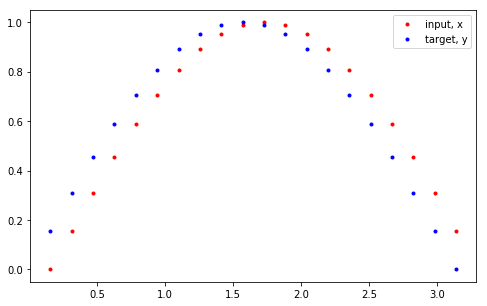

In [43]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
#print("time step", time_steps)
data = np.sin(time_steps)
#print("data", data)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension
#print("after resize", data)
x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

---
## Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


### Check the input and output dimensions

As a check that your model is working as expected, test out how it responds to input data.

In [14]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [110]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [111]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [113]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1
        #print("check data too", data)
        x = data[:-1]
        y = data[1:]
        #print("this is x", x.shape)
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)
        #print("x tensor", x_tensor.shape)
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.323261559009552


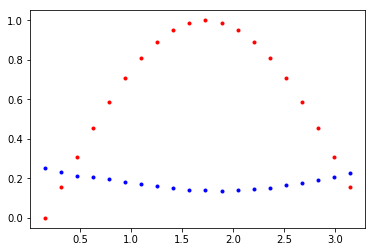

Loss:  0.0656658336520195


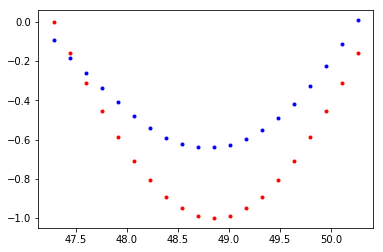

Loss:  0.010316857136785984


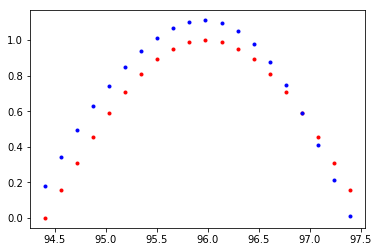

Loss:  0.00044379959581419826


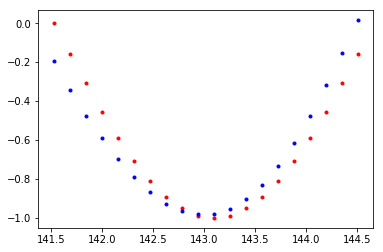

Loss:  0.0005308375111781061


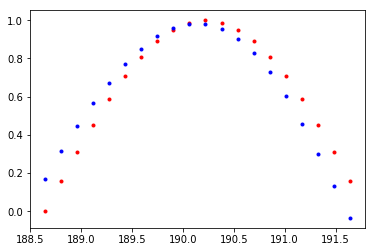

In [114]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

### Time-Series Prediction

Time-series prediction can be applied to many tasks. Think about weather forecasting or predicting the ebb and flow of stock market prices. You can even try to generate predictions much further in the future than just one time step!

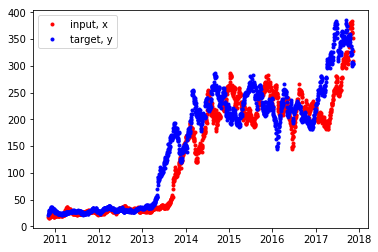

In [115]:
import pandas as pd 

data = []

df = pd.read_csv('data/Stocks/tsla.us.txt')

df['Date'] = pd.to_datetime(df['Date'])
data.append(df)

x = df['Close'][:-90] # all but the last piece of data
y = df['Close'][90:] # all but the first

# display the data
plt.plot(df['Date'][90:], x, 'r.') # x
plt.plot(df['Date'][90:], y, 'b.') # y
plt.legend(['input, x', 'target, y'])
#plt.plot(x, color='red', linewidth=10)
#plt.plot(y, color='blue', linewidth=10)
plt.show()

In [206]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [207]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001) 

In [208]:
def stock_train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    
    for batch_i, step in enumerate(range(n_steps)):
      
        df = pd.read_csv('data/Stocks/tsla.us.txt')
        
        train_data = np.round(len(df)*0.8)
        
        df = df[0:int(train_data)]
        
        df['Date'] = pd.to_datetime(df['Date'])
      
        data = np.array(df['Close'])
     
        data.resize((len(df['Date']),1))
        
        x = data[:-90] # all but the last piece of data
        y = data[90:] # all but the first
        
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)
        #print("x tensor", x_tensor.shape)
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(df['Date'][90:], x, 'r.') # input
            plt.plot(df['Date'][90:], prediction.data.numpy(), 'b.') # predictions
            plt.legend(['input, x', 'training output, y'])
            plt.show()
    
    return rnn


Loss:  24637.40625


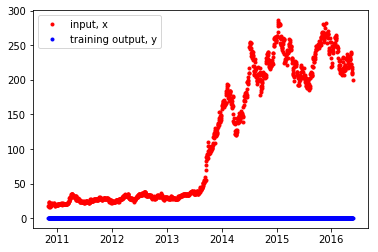

Loss:  20564.783203125


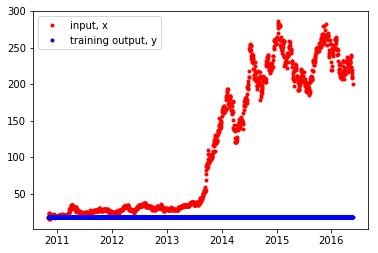

Loss:  17517.5234375


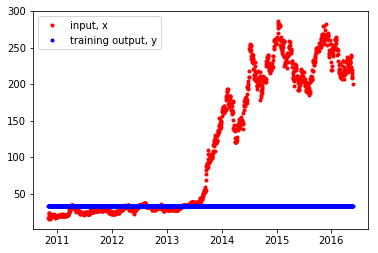

Loss:  14883.26953125


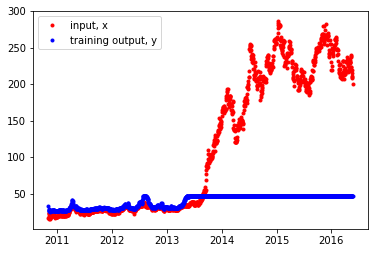

Loss:  12511.9130859375


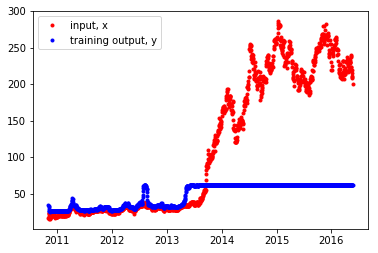

Loss:  10478.501953125


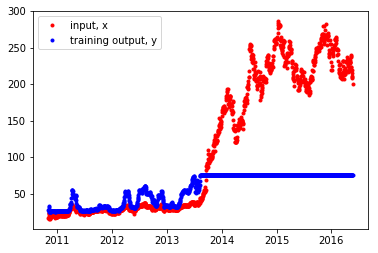

Loss:  8581.3505859375


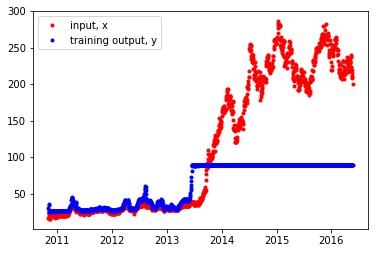

Loss:  6968.22705078125


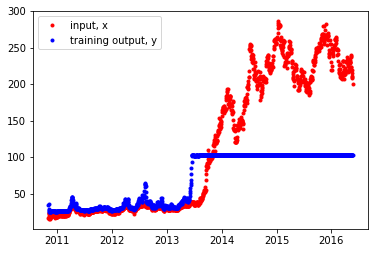

Loss:  5585.58544921875


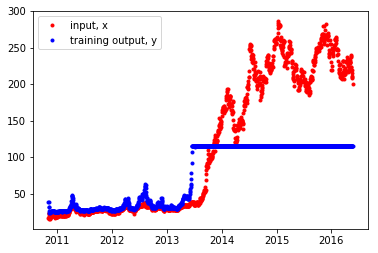

Loss:  4416.49951171875


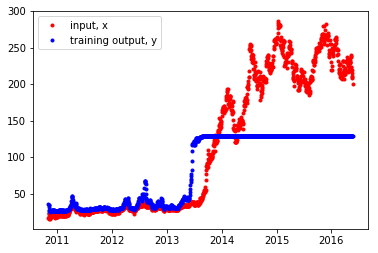

Loss:  3474.490966796875


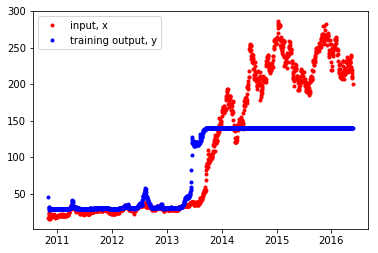

Loss:  2655.44189453125


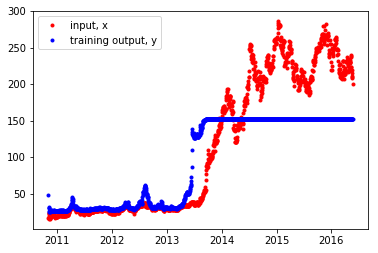

Loss:  2014.5635986328125


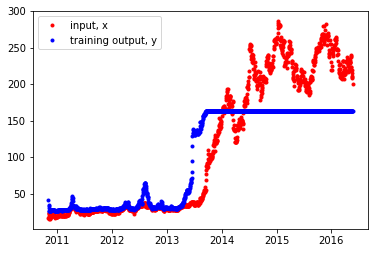

Loss:  1521.071044921875


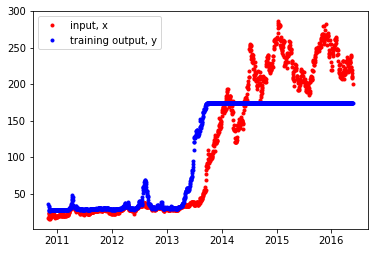

Loss:  1158.0194091796875


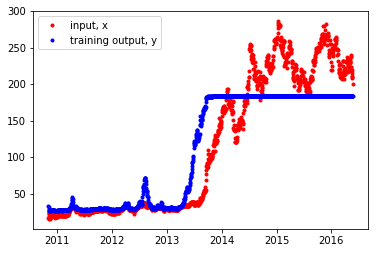

Loss:  891.8712158203125


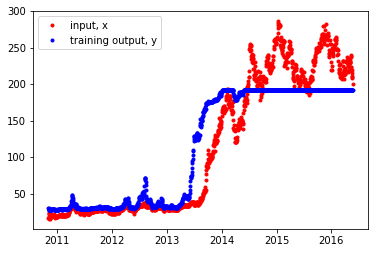

Loss:  675.1707763671875


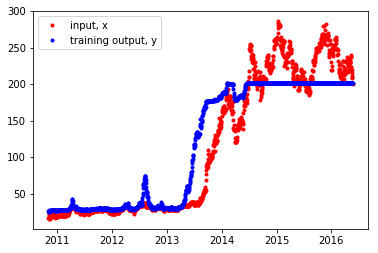

Loss:  523.0458984375


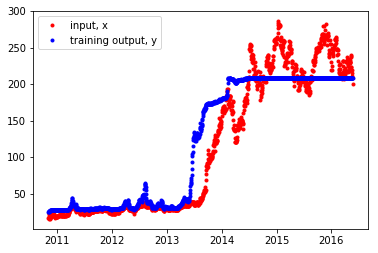

Loss:  516.5562133789062


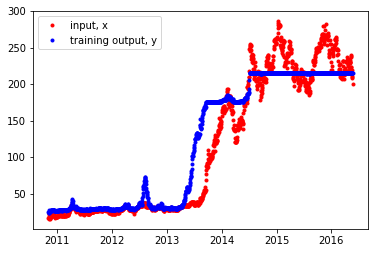

Loss:  481.2831726074219


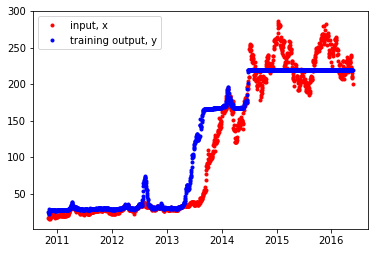

Loss:  389.4173889160156


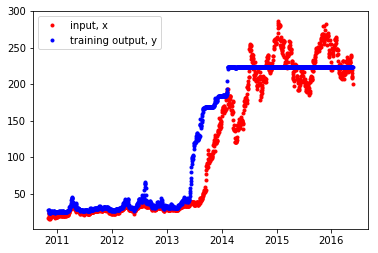

Loss:  338.72705078125


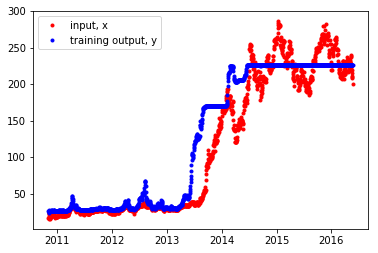

Loss:  398.79046630859375


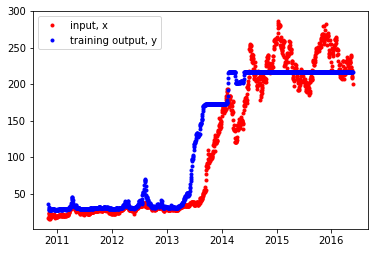

Loss:  624.7609252929688


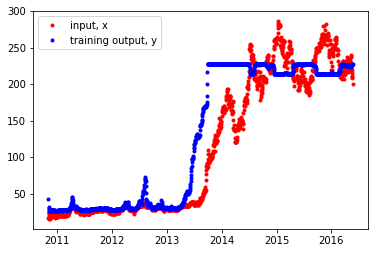

Loss:  606.6333618164062


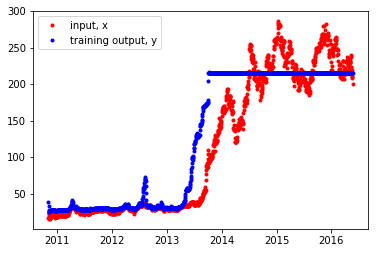

Loss:  612.6163330078125


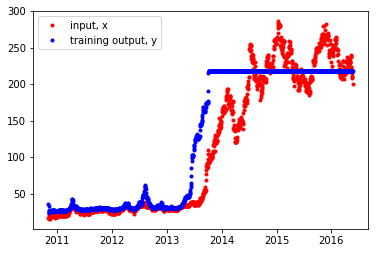

Loss:  514.0069580078125


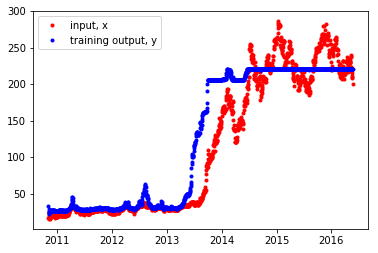

Loss:  505.5281982421875


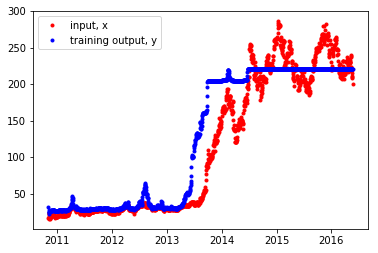

Loss:  487.94232177734375


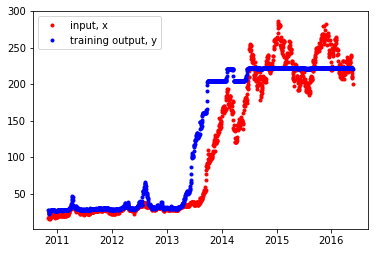

Loss:  493.12115478515625


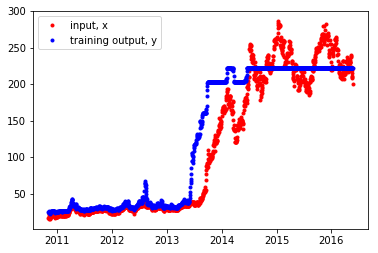

Loss:  482.65557861328125


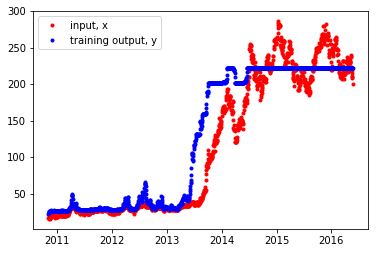

Loss:  508.0306091308594


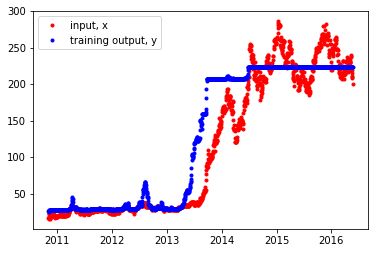

Loss:  493.8973388671875


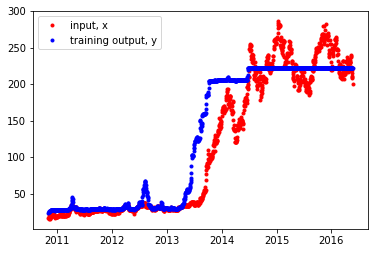

Loss:  403.9337463378906


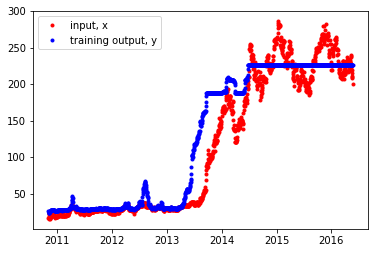

Loss:  399.1195068359375


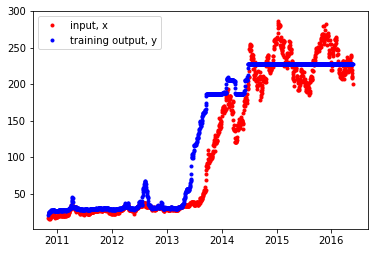

Loss:  385.59881591796875


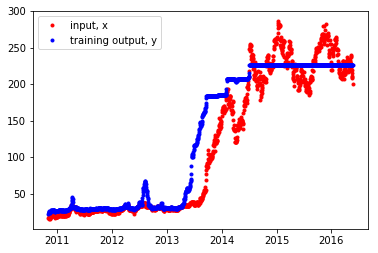

Loss:  460.26776123046875


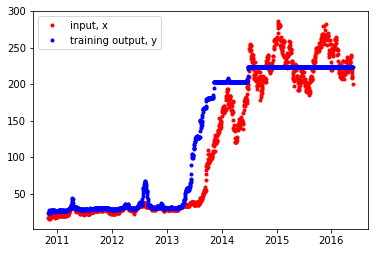

Loss:  455.1352844238281


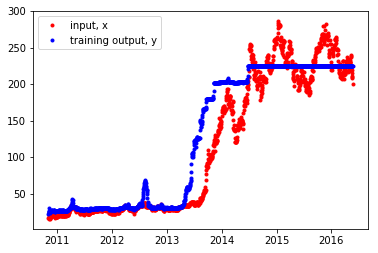

Loss:  503.5313415527344


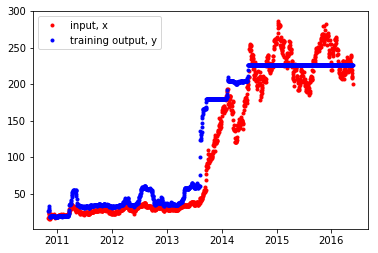

Loss:  486.96527099609375


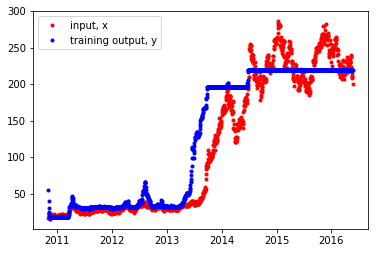

In [209]:
n_steps = 20000
print_every = 500

trained_rnn = stock_train(rnn, n_steps, print_every)

Loss:  446.4244689941406


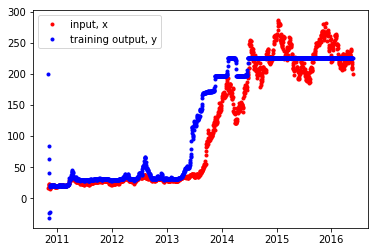

Loss:  380.02386474609375


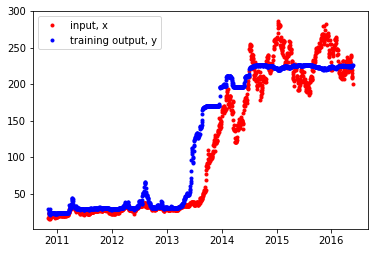

Loss:  282.9874267578125


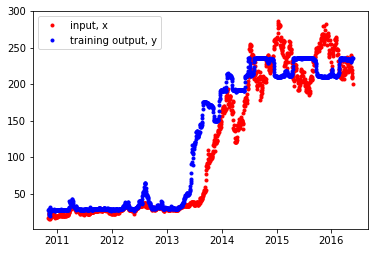

Loss:  358.6802673339844


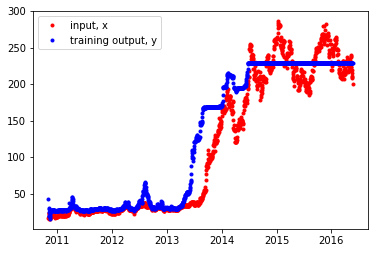

Loss:  331.509521484375


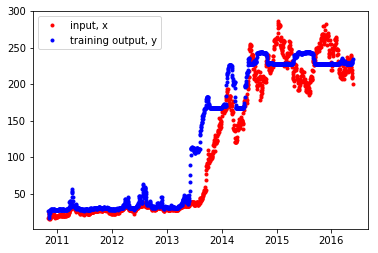

Loss:  394.48101806640625


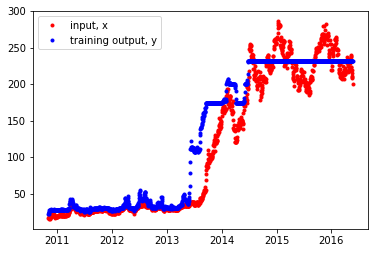

Loss:  380.8382568359375


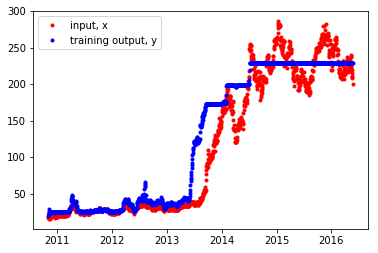

Loss:  391.23028564453125


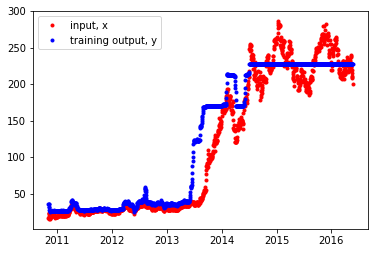

Loss:  497.1314392089844


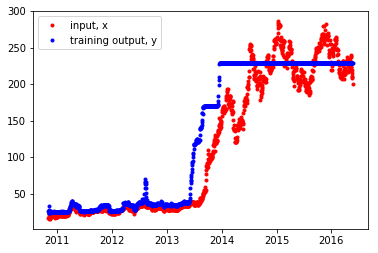

Loss:  358.8647155761719


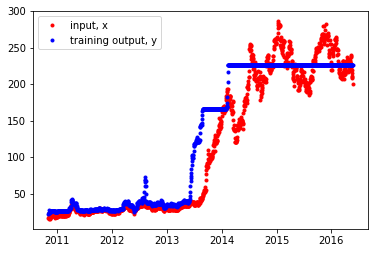

Loss:  336.3126525878906


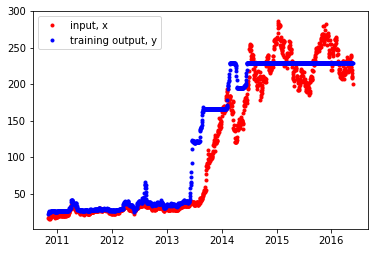

Loss:  334.0157470703125


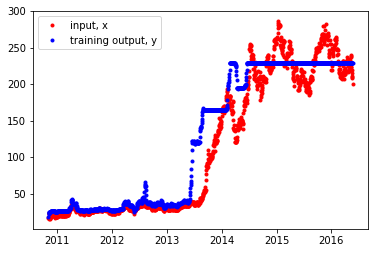

Loss:  329.44549560546875


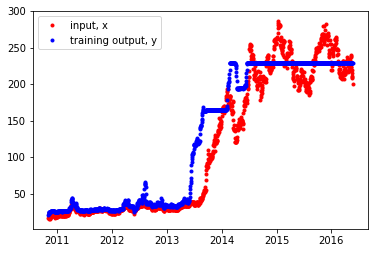

Loss:  334.587158203125


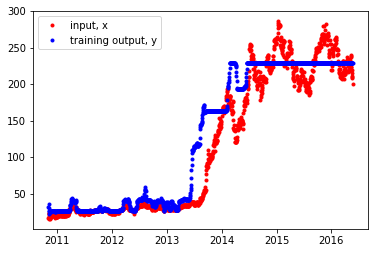

Loss:  348.0182189941406


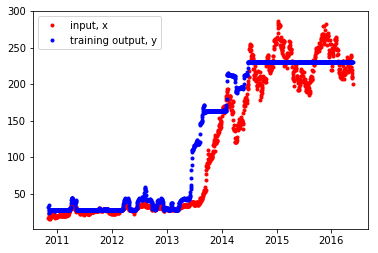

Loss:  326.9358825683594


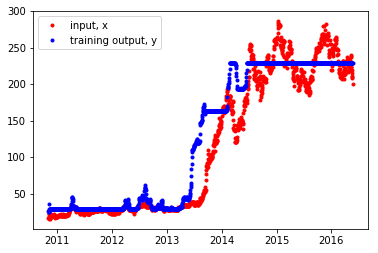

Loss:  318.34332275390625


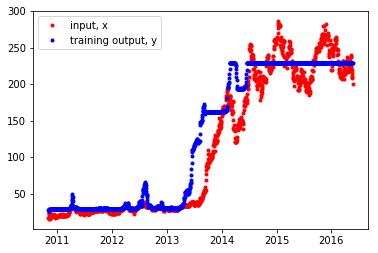

Loss:  316.5400390625


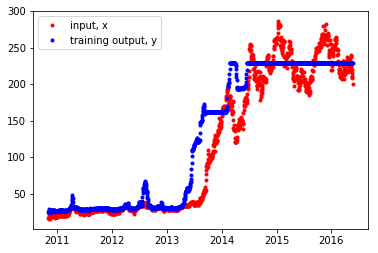

Loss:  316.0596618652344


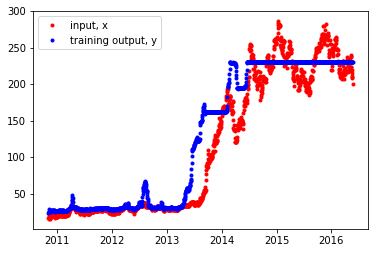

Loss:  425.1698913574219


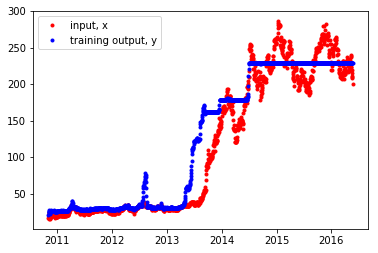

Loss:  424.72283935546875


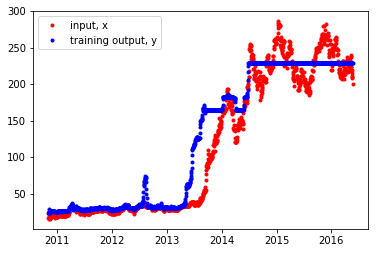

Loss:  328.9854431152344


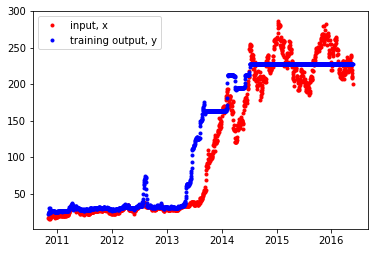

Loss:  332.4900207519531


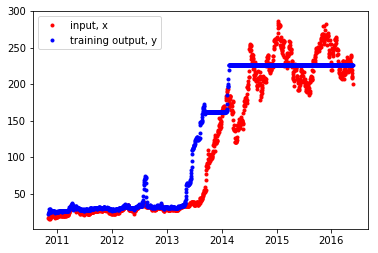

Loss:  334.3316955566406


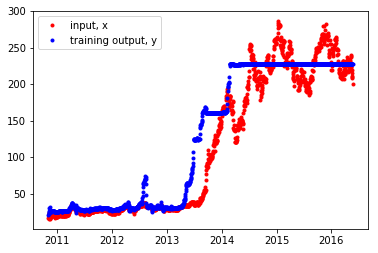

Loss:  353.5502014160156


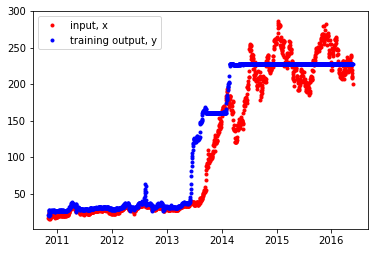

Loss:  363.6002502441406


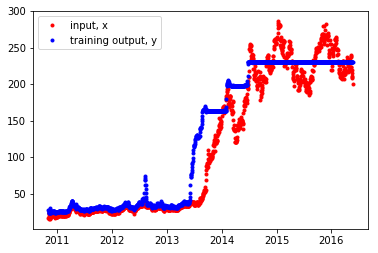

Loss:  340.1839294433594


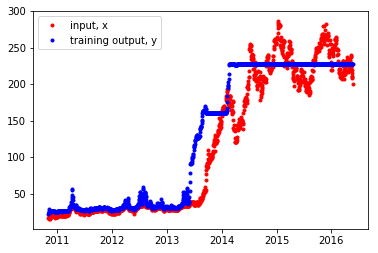

Loss:  356.7388000488281


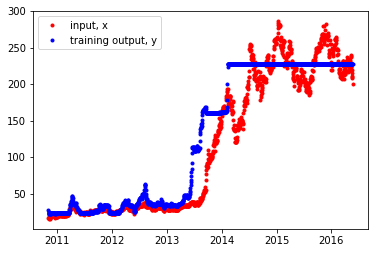

Loss:  393.558837890625


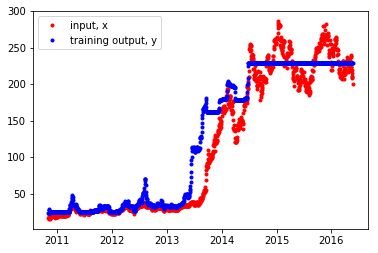

Loss:  408.1136169433594


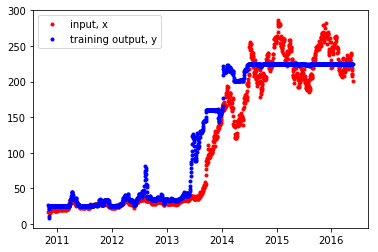

Loss:  318.4398498535156


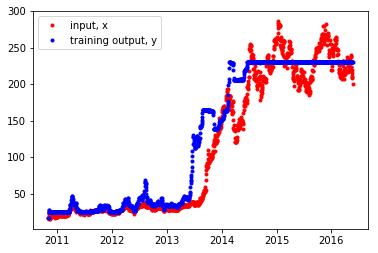

Loss:  311.1103820800781


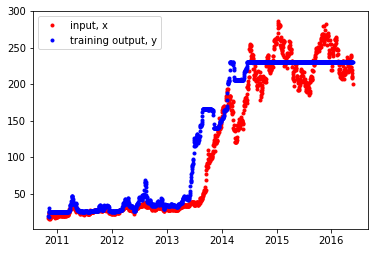

Loss:  307.53466796875


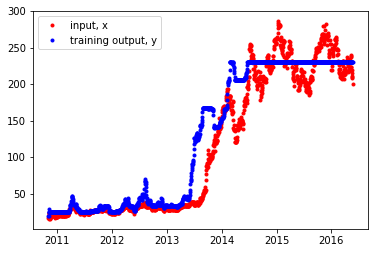

Loss:  304.6740417480469


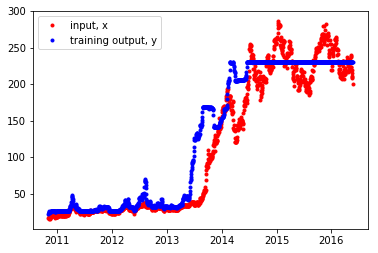

Loss:  301.19525146484375


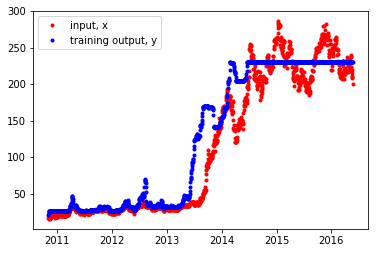

Loss:  582.7421264648438


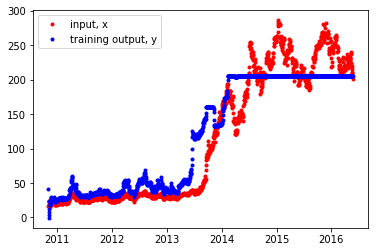

Loss:  410.60009765625


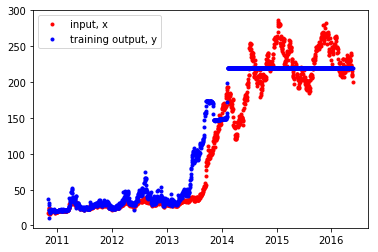

Loss:  357.61285400390625


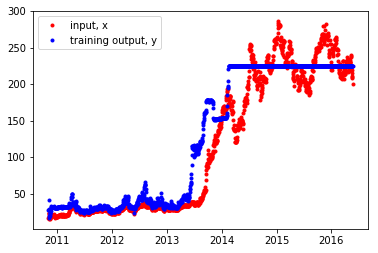

Loss:  343.78778076171875


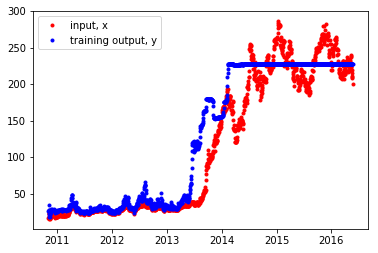

Loss:  315.6327819824219


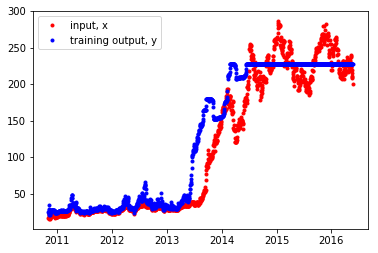

In [210]:
n_steps = 20000
print_every = 500

trained_rnn = stock_train(rnn, n_steps, print_every)